# Image classification with Vision Transformer

**Author:** [SONY ANNEM](https://www.linkedin.com/in/sony-annem-648273231/)<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

In [2]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.0 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.callbacks import EarlyStopping
import pandas as pd
import cv2
from PIL import Image
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train=ImageDataGenerator(rescale=1/255)
test=ImageDataGenerator(rescale=1/255)

In [ ]:
#data="/content/drive/MyDrive/Dataset/train/"
#train_dataset=train.flow_from_directory('/content/drive/MyDrive/Dataset/train/',target_size=(200,200), batch_size=3, class_mode='binary')

In [6]:
import glob
smile=glob.glob('/content/drive/MyDrive/Dataset/train/smile/*.*')
non_smile=glob.glob('/content/drive/MyDrive/Dataset/train/non_smile/*.*')
data=[]
labels=[]
for i in smile:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (32,32))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in non_smile:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (32,32))
    image=np.array(image)
    data.append(image)
    labels.append(1)  

data=np.array(data)
labels=np.array(labels)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

## Prepare the data

## Configure the hyperparameters

I have taken dataset from kaggle repository and mpdified it like imporoving size of images by data augumentaion and added some custom images that belongs to my friends.
In order to run this code we first need to  download and specify path of the dataset. 

In [7]:
learning_rate = 0.001
input_shape = (32, 32, 3)
num_classes = 2
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [17]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [18]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


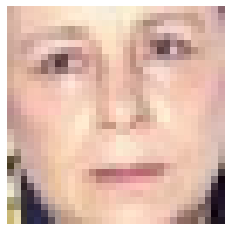

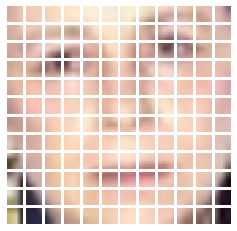

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
#image1= ("/content/drive/MyDrive/WhatsApp Image 2022-11-04 at 10.53.22 AM.jpeg")
#image = x_train[np.random.choice(range(image))]
#plt.imshow(image3)
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    #print(patch_img.shape)
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [20]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



## Build the ViT model

.

In [21]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [22]:
#from IPython.core import history
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopper=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, early_stopper],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history
   # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
#     from keras.utils import load_img
#     import cv2
#     from tensorflow.keras.utils import img_to_array
    
#     i=cv2.imread("/content/drive/MyDrive/WhatsApp Image 2022-10-30 at 12.05.52 AM.jpeg")
#     from keras.preprocessing import image
#     p = img_to_array(load_img("/content/drive/MyDrive/WhatsApp Image 2022-10-30 at 12.05.52 AM.jpeg", target_size=(32,32))) / 255

# #i=i.resize(32,32)
# #p=cv2.resize(i, (32,32))
# #p=img_to_array(i)
#     p=np.expand_dims(p, axis=0)

# #p
#     p=p.astype("uint8")

#     plt.imshow(i)
#     result=model.predict(p)
#     print(result)
#     if (result==0).any():
#       print("Sad")
#     else:
#      print("Happy")



#     return model
#print(model.summary)
    #return model


vit_classifier = create_vit_classifier()
history= run_experiment(vit_classifier)
#print(model)


Epoch 1/100
4/4 [==============================] - 15s 919ms/step - loss: 7.3472 - accuracy: 0.5126 - top-5-accuracy: 1.0000 - val_loss: 7.3357 - val_accuracy: 0.4742 - val_top-5-accuracy: 1.0000
Epoch 2/100
4/4 [==============================] - 1s 188ms/step - loss: 4.0306 - accuracy: 0.5722 - top-5-accuracy: 1.0000 - val_loss: 2.3338 - val_accuracy: 0.4742 - val_top-5-accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 1s 436ms/step - loss: 1.3519 - accuracy: 0.6044 - top-5-accuracy: 1.0000 - val_loss: 0.4785 - val_accuracy: 0.7732 - val_top-5-accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 1s 160ms/step - loss: 0.7105 - accuracy: 0.7087 - top-5-accuracy: 1.0000 - val_loss: 0.4926 - val_accuracy: 0.7216 - val_top-5-accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 1s 157ms/step - loss: 0.6444 - accuracy: 0.7236 - top-5-accuracy: 1.0000 - val_loss: 0.5706 - val_accuracy: 0.7732 - val_top-5-accuracy: 1.0000
Epoch 6/100
4/4 [=======

Dataset is small so it will leads to over fitting ptoblem

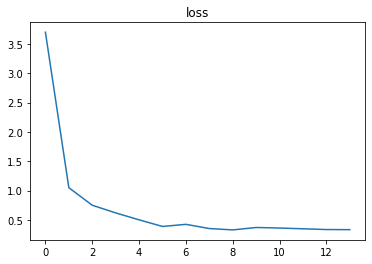

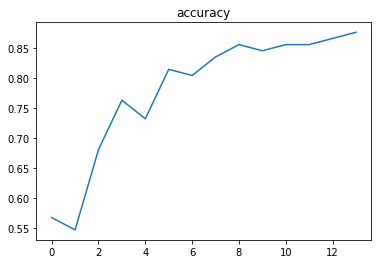

In [16]:
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()
plt.plot(history.history['val_accuracy'])
plt.title("accuracy")
plt.show()

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
model = Sequential([Conv2D(128,(3,3),activation="relu",input_shape= x_train.shape[1:]),
                    MaxPooling2D((2,2)),
                    Dropout(0.3),
                    BatchNormalization(),
                    Conv2D(64,(3,3),activation="relu"),
                    MaxPooling2D((2,2)),
                    Conv2D(64,(3,3),activation="relu"),
                    Flatten(),
                    Dense(128,activation="relu"),
                    Dropout(0.3),
                    BatchNormalization(),
                    Dense(128,activation="relu"),
                    Dense(1,activation="sigmoid")])
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0

In [14]:

callback = EarlyStopping(patience=5)

In [15]:
train_hist = model.fit(x_train,y_train,epochs=100,batch_size=8,callbacks=[callback],validation_split=0.1)

Epoch 1/80
109/109 [==============================] - 1s 5ms/step - loss: 0.2449 - accuracy: 0.9002 - val_loss: 0.1650 - val_accuracy: 0.9175
Epoch 2/80
109/109 [==============================] - 1s 6ms/step - loss: 0.2065 - accuracy: 0.9243 - val_loss: 0.3160 - val_accuracy: 0.8763
Epoch 3/80
109/109 [==============================] - 1s 5ms/step - loss: 0.1785 - accuracy: 0.9438 - val_loss: 0.1629 - val_accuracy: 0.9381
Epoch 4/80
109/109 [==============================] - 1s 5ms/step - loss: 0.1953 - accuracy: 0.9300 - val_loss: 0.1401 - val_accuracy: 0.9588
Epoch 5/80
109/109 [==============================] - 1s 5ms/step - loss: 0.1708 - accuracy: 0.9438 - val_loss: 0.1789 - val_accuracy: 0.9381
Epoch 6/80
109/109 [==============================] - 1s 5ms/step - loss: 0.1472 - accuracy: 0.9518 - val_loss: 0.1933 - val_accuracy: 0.9175
Epoch 7/80
109/109 [==============================] - 1s 5ms/step - loss: 0.3360 - accuracy: 0.8761 - val_loss: 0.6849 - val_accuracy: 0.7113
Epoch 

In [16]:
model.evaluate(x_test,y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.2475 - accuracy: 0.9342


[0.24750865995883942, 0.9341563582420349]